In [3]:
import tensorflow as tf
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import *
from sklearn.metrics import *
from tensorflow.keras.models import load_model
import itertools
from sklearn.metrics import confusion_matrix

In [4]:
input_path='Dataset/Val/'
test_tfrecord = 'XRay_test.tfrecords'
img_size=224
batch_size = 32

In [5]:
def read_directory():
    data_filenames = []
    data_labels = []

    for filename in os.listdir(input_path + 'covid'):
        data_filenames.append(input_path + 'covid/' + filename)
        data_labels.append(0)

    for filename in os.listdir(input_path + 'normal'):
        data_filenames.append(input_path + 'normal/' + filename)
        data_labels.append(1)

    for filename in os.listdir(input_path + 'pneumonia'):
            data_filenames.append(input_path + 'pneumonia/' + filename)
            data_labels.append(2)
        
   
    
    tmp_uni = list(zip(data_filenames, data_labels))
    random.shuffle(tmp_uni)
    data_filenames,data_labels = zip(*tmp_uni)

    return  data_filenames, data_labels

In [6]:
def build_test_tfrecord(test_filenames,test_labels):  # Generate TFRecord of test set
    with tf.io.TFRecordWriter(test_tfrecord)as writer:
        for filename, label in zip(test_filenames, test_labels):
            image = open(filename, 'rb').read()

            feature = {
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

In [7]:
def get_test_dataset(test_tfrecord):
    raw_test_dataset = tf.data.TFRecordDataset(test_tfrecord)
    test_dataset = raw_test_dataset.map(_parse_example)

    return test_dataset

In [8]:
def _parse_example(example_string):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    feature_dict = tf.io.parse_single_example(example_string, feature_description)
    feature_dict['image'] = tf.io.decode_png(feature_dict['image'], channels=3)
    feature_dict['image'] = tf.image.resize(feature_dict['image'], [img_size, img_size]) / 255.0
    return feature_dict['image'], feature_dict['label']




def get_test_dataset(test_tfrecord):
    raw_test_dataset = tf.data.TFRecordDataset(test_tfrecord)
    test_dataset = raw_test_dataset.map(_parse_example)

    return test_dataset

In [9]:
def data_Preprocessing(test_dataset):

    test_dataset = test_dataset.batch(batch_size)
    test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return test_dataset

In [10]:
def test(test_labels):
    test_labels = np.array(test_labels)
    model = load_model('mymodel.h5')
    
    print('Testing:')
    
    predIdxs = model.predict(test_dataset)
    predIdxs = np.argmax(predIdxs, axis=1) 

    target_names = ['COVID', 'NORMAL', 'Viral Pneumonia']
    print('\n')
    print(classification_report(test_labels, predIdxs, target_names=target_names, digits=5))
    
    cm = confusion_matrix(test_labels, predIdxs)
    return cm

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="plasma"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Info of test_dataset <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
Testing:


                 precision    recall  f1-score   support

          COVID    0.93211   0.98744   0.95898       876
         NORMAL    0.99620   0.94585   0.97037      1385
Viral Pneumonia    0.98535   0.99852   0.99189      1347

       accuracy                        0.97561      3608
      macro avg    0.97122   0.97727   0.97375      3608
   weighted avg    0.97659   0.97561   0.97564      3608





Confusion matrix, without normalization
[[ 865    3    8]
 [  63 1310   12]
 [   0    2 1345]]


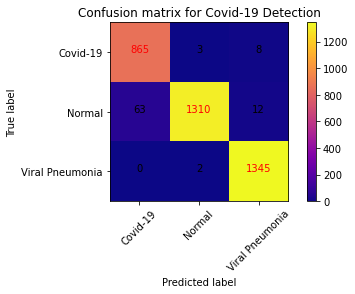

In [12]:
if __name__ == "__main__":
    
    test_filenames, test_labels = read_directory()

    build_test_tfrecord(test_filenames, test_labels)

    test_dataset = get_test_dataset(test_tfrecord)

    print('Info of test_dataset', type(test_dataset))

    test_dataset = data_Preprocessing( test_dataset) 

    
    cm=test(test_labels)
    
    
    
    print('\n\n\n')
    plt.figure()
    class_names = ["Covid-19","Normal",'Viral Pneumonia']
    plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix for Covid-19 Detection',cmap="plasma")